# Imports

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.ensemble import BalancedBaggingClassifier

from pathlib import Path

# Dataset Listing and Loading

In [2]:
def read_data(path: Path):
    if path.suffix == ".csv":
        return pd.read_csv(path)
    else:                       # Excel
        return pd.read_excel(path)

- Dataset path:

In [3]:
DATA_DIR   = Path("datasets")          # CSV files
CSV_FILES  = sorted(DATA_DIR.glob("*.csv"))
assert CSV_FILES, "No CSV found"


- All avalable datasets:

In [4]:
for i, f in enumerate(CSV_FILES):
    print(i ,f.name)

0 abc3_oqmd_cs.csv
1 perov_form.csv
2 perov_stab.csv
3 vehicle1.csv
4 vehicle2.csv
5 wisconsin.csv


# Machine Learning Pipeline

## ML Model

In [5]:

CV         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CLASSIFIER = RandomForestClassifier(n_estimators=300,
                                    n_jobs=-1,
                                    random_state=42)


## Sampling Algorithms

In [6]:

SAMPLERS   = {
    "None"          : None,
    "SMOTE"         : SMOTE(random_state=42),
    "UpSample"      : RandomOverSampler(random_state=42),
    "DownSample"    : RandomUnderSampler(random_state=42),
    "CNN"           : CondensedNearestNeighbour(random_state=10, n_jobs=-1),
    "NC"            : NeighbourhoodCleaningRule()
}


## Model Metrics

In [7]:

METRICS    = ["accuracy", "macro_precision", "macro_recall", "macro_f1",
              "weighted_precision", "weighted_recall", "weighted_f1", "mcc"]

## Model Pipeline

In [8]:
def build_pipeline(sampler) -> ImbPipeline:
    steps = [
        ("impute", SimpleImputer(strategy="median")),
        ("scale" , StandardScaler()),          # optional but cheap
    ]
    if sampler is not None:
        steps.append(("sample", sampler))
    steps.append(("clf", CLASSIFIER))
    return ImbPipeline(steps)

## Scoring function

In [9]:
def score_fold(y_true, y_pred) -> dict:
    return {
        "accuracy"          : accuracy_score(y_true, y_pred),
        "macro_precision"   : precision_score(y_true, y_pred,
                                              average="macro", zero_division=0),
        "macro_recall"      : recall_score(y_true, y_pred,
                                           average="macro", zero_division=0),
        "macro_f1"          : f1_score(y_true, y_pred,
                                       average="macro", zero_division=0),
        "weighted_precision": precision_score(y_true, y_pred,
                                              average="weighted", zero_division=0),
        "weighted_recall"   : recall_score(y_true, y_pred,
                                           average="weighted", zero_division=0),
        "weighted_f1"       : f1_score(y_true, y_pred,
                                       average="weighted", zero_division=0),
        "mcc"               : matthews_corrcoef(y_true, y_pred),
    }

# Master loop – run pipelines

For all Datasets
- Loading Dataset
- Label Encoding
- Loop for all Sampling Algorithms
- Build Pipeline
- Train-Test model with StratifiedkFold
- Save the scores

In [10]:
scores = {m: {s: {} for s in SAMPLERS} for m in METRICS}   # metric -> sampler -> dataset -> score

for dataset_path in CSV_FILES:
    ds_name = dataset_path.stem
    print(f"\nProcessing {ds_name}" , end="\t\tSize = ")
    
    # load + basic cleaning
    df = read_data(dataset_path)
    print(df.shape, "\t", "No. of classes = ", df.iloc[:, -1].nunique())

    X = df.iloc[:, :-1].copy()
    y = LabelEncoder().fit_transform(df.iloc[:, -1])
    
    cat_cols = X.select_dtypes(exclude=np.number).columns
    if len(cat_cols):
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    for samp_name, sampler in SAMPLERS.items():
        pipe = build_pipeline(sampler)
        fold_scores = {m: [] for m in METRICS}
        
        for train_idx, val_idx in CV.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            pipe.fit(X_train, y_train)          # ALL steps fitted only on train
            y_pred = pipe.predict(X_val)
            
            for k, v in score_fold(y_val, y_pred).items():
                fold_scores[k].append(v)
        
        # mean across folds
        for m in METRICS:
            scores[m][samp_name][ds_name] = np.mean(fold_scores[m])


Processing abc3_oqmd_cs		Size = (29209, 59) 	 No. of classes =  7

Processing perov_form		Size = (1505, 29) 	 No. of classes =  2

Processing perov_stab		Size = (3469, 29) 	 No. of classes =  2

Processing vehicle1		Size = (846, 19) 	 No. of classes =  2

Processing vehicle2		Size = (846, 19) 	 No. of classes =  2

Processing wisconsin		Size = (683, 10) 	 No. of classes =  2


# Results

- Scores

In [11]:
df_per_metric = []
for metric in METRICS:
    df = pd.DataFrame(scores[metric])#.T   # samplers × datasets
    # df = df.T                             # datasets × samplers
    df.name = metric
    df_per_metric.append(df)

- Display Scores

In [12]:
for df in df_per_metric:
    print("="*80)
    print(df.name)
    display(df)
    print("")

accuracy


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.903317,0.900099,0.900955,0.705467,0.723442,0.853436
perov_form,0.926246,0.914950,0.913621,0.866445,0.884385,0.904319
perov_stab,0.935139,0.933699,0.935428,0.930815,0.920727,0.908622
vehicle1,0.794333,0.786022,0.791932,0.760090,0.787247,0.777807
vehicle2,0.985820,0.986996,0.986996,0.971612,0.971619,0.981086
wisconsin,0.973637,0.976567,0.973647,0.975118,0.969257,0.976578



macro_precision


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.890646,0.869960,0.877844,0.584143,0.627645,0.820771
perov_form,0.913819,0.879613,0.880652,0.799187,0.822390,0.855917
perov_stab,0.933442,0.931881,0.933494,0.928533,0.919164,0.909090
vehicle1,0.734721,0.723185,0.730208,0.724772,0.731430,0.729080
vehicle2,0.983178,0.983880,0.985350,0.955166,0.953584,0.975357
wisconsin,0.968825,0.970683,0.968102,0.968810,0.962740,0.970051



macro_recall


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.864475,0.873956,0.870073,0.759460,0.663735,0.776584
perov_form,0.857802,0.861018,0.854445,0.865786,0.857702,0.861132
perov_stab,0.935374,0.934394,0.936153,0.933105,0.925343,0.915723
vehicle1,0.691217,0.738290,0.733086,0.782797,0.757367,0.773576
vehicle2,0.979899,0.982224,0.980699,0.974814,0.976299,0.975245
wisconsin,0.973915,0.979042,0.974875,0.977963,0.971492,0.980046



macro_f1


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.876577,0.871510,0.873422,0.617315,0.642312,0.782499
perov_form,0.881557,0.869260,0.865826,0.822277,0.836805,0.857915
perov_stab,0.934237,0.932842,0.934587,0.930107,0.920193,0.908284
vehicle1,0.705212,0.728827,0.729671,0.729287,0.737779,0.738048
vehicle2,0.981356,0.982976,0.982856,0.963957,0.963917,0.975216
wisconsin,0.971158,0.974472,0.971253,0.972957,0.966578,0.974553



weighted_precision


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.902107,0.900131,0.900663,0.767757,0.726971,0.857709
perov_form,0.925060,0.913861,0.912194,0.891976,0.894482,0.905920
perov_stab,0.935621,0.934482,0.936088,0.932575,0.925351,0.917479
vehicle1,0.783243,0.795429,0.796182,0.823577,0.807841,0.816299
vehicle2,0.985981,0.987077,0.987114,0.973729,0.973721,0.981187
wisconsin,0.974128,0.977449,0.974257,0.976123,0.970505,0.977689



weighted_recall


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.903317,0.900099,0.900955,0.705467,0.723442,0.853436
perov_form,0.926246,0.914950,0.913621,0.866445,0.884385,0.904319
perov_stab,0.935139,0.933699,0.935428,0.930815,0.920727,0.908622
vehicle1,0.794333,0.786022,0.791932,0.760090,0.787247,0.777807
vehicle2,0.985820,0.986996,0.986996,0.971612,0.971619,0.981086
wisconsin,0.973637,0.976567,0.973647,0.975118,0.969257,0.976578



weighted_f1


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.902380,0.900019,0.900710,0.723209,0.724154,0.843798
perov_form,0.923549,0.913872,0.912042,0.873433,0.887672,0.904802
perov_stab,0.935213,0.933801,0.935528,0.930999,0.921016,0.908987
vehicle1,0.783996,0.789422,0.792728,0.773291,0.792825,0.787280
vehicle2,0.985789,0.986991,0.986953,0.972010,0.972011,0.981084
wisconsin,0.973703,0.976677,0.973753,0.975257,0.969420,0.976713



mcc


,None,SMOTE,UpSample,DownSample,CNN,NC
abc3_oqmd_cs,0.874381,0.870466,0.871479,0.635717,0.642498,0.811795
perov_form,0.769406,0.740114,0.734241,0.661487,0.678853,0.716785
perov_stab,0.868812,0.866270,0.869642,0.861625,0.844484,0.824787
vehicle1,0.423054,0.461027,0.462782,0.504186,0.487529,0.500486
vehicle2,0.963004,0.966074,0.965981,0.929636,0.929546,0.950570
wisconsin,0.942709,0.949671,0.942944,0.946713,0.934165,0.950029


# 7.  Bar-plots: % change vs SMOTE

- scores of SMOTE is set as baseline

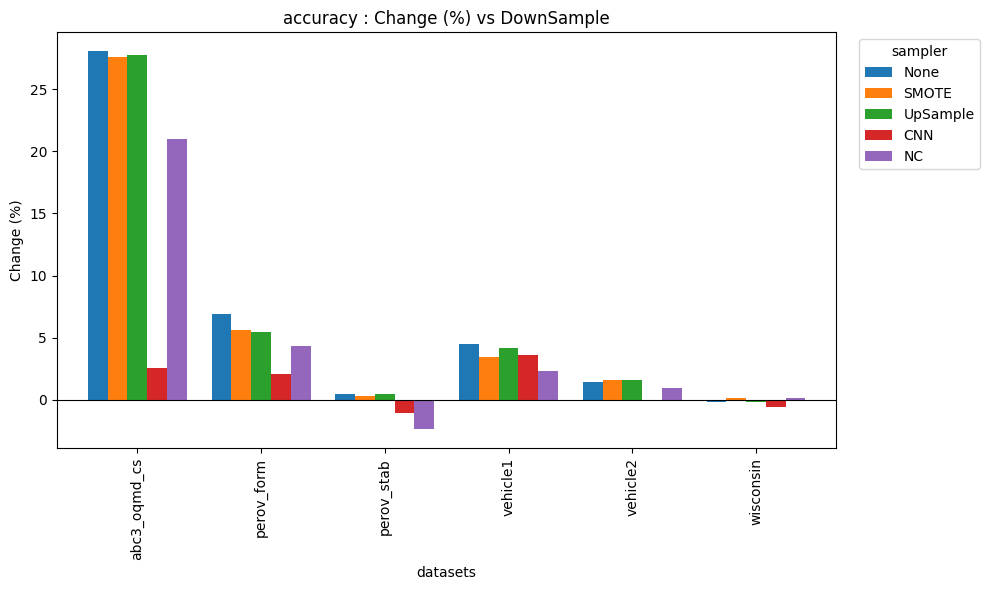

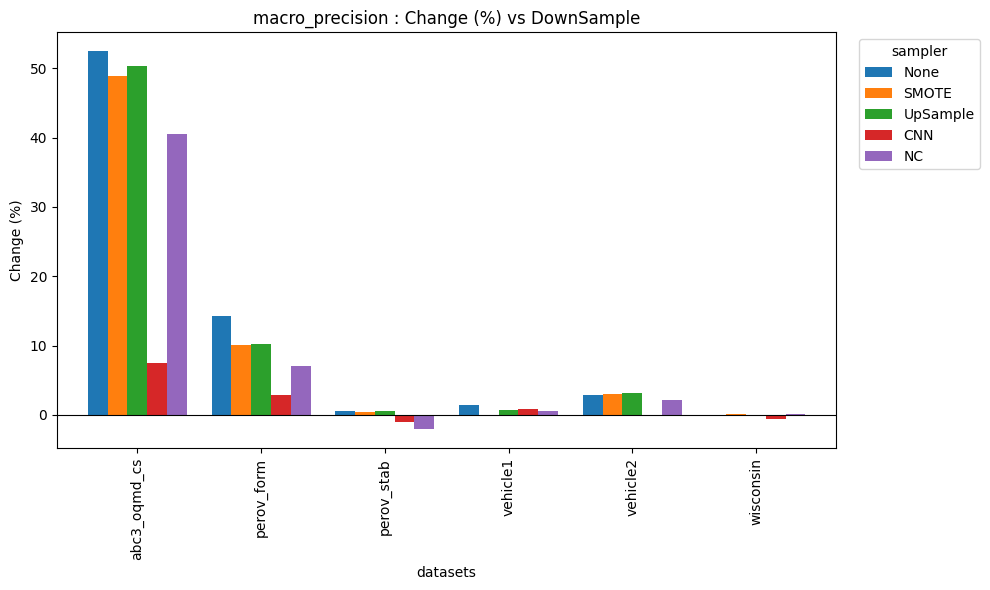

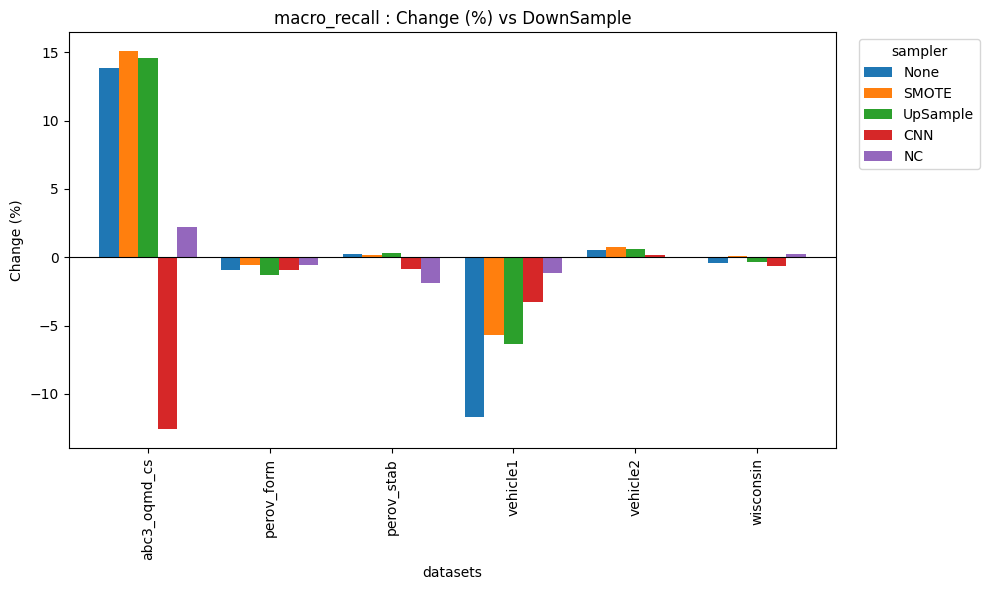

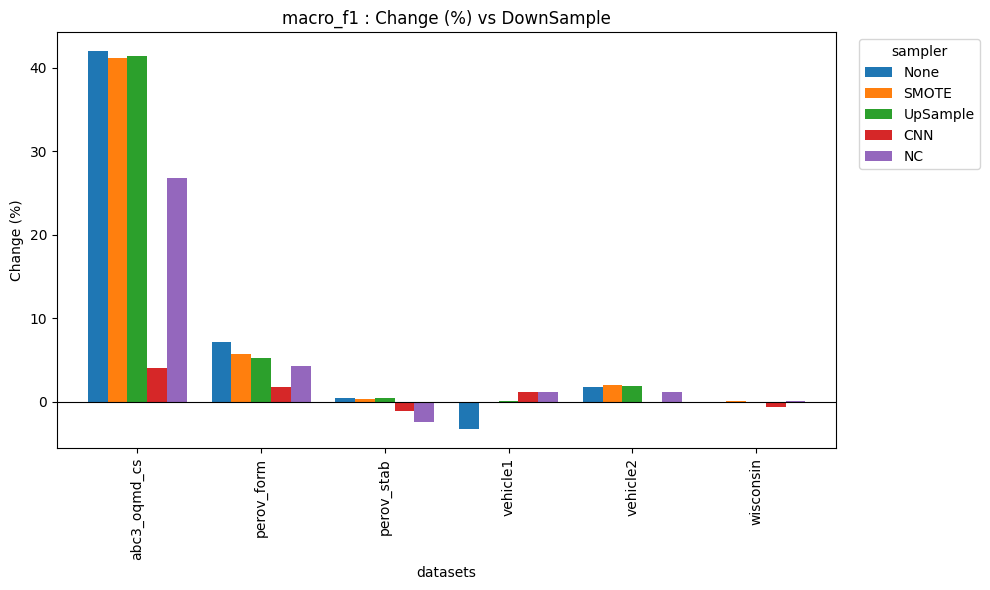

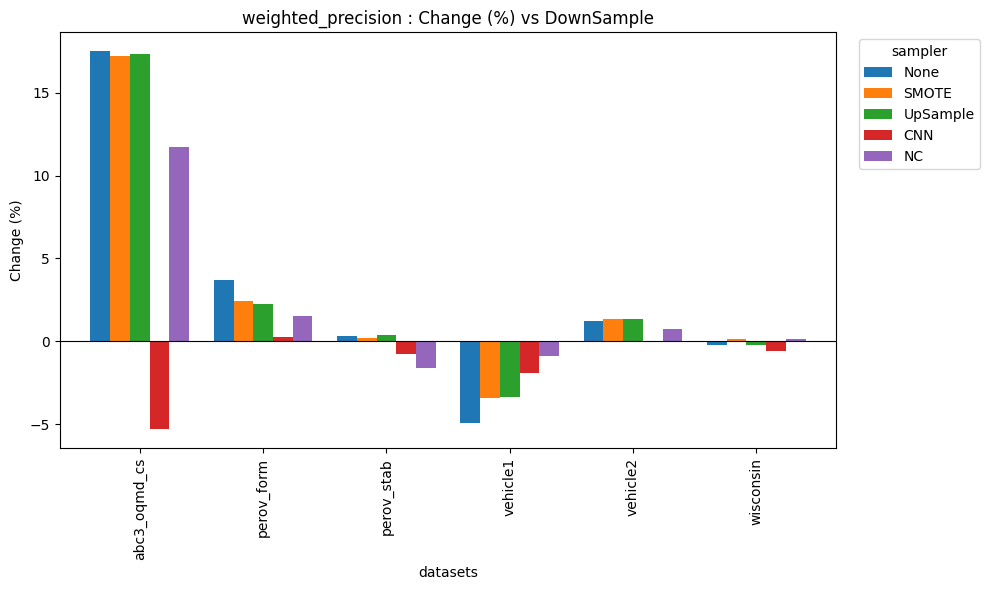

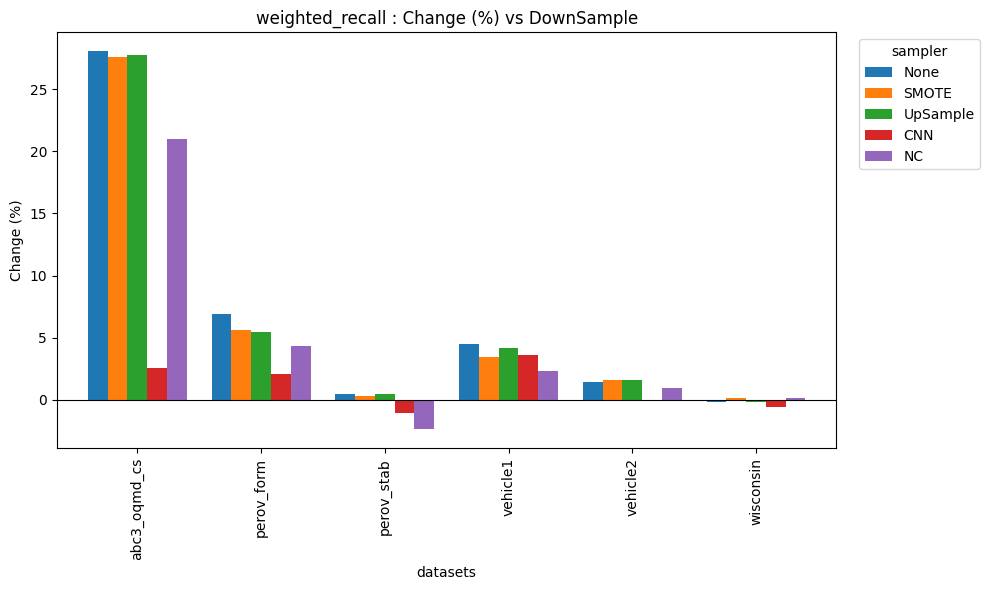

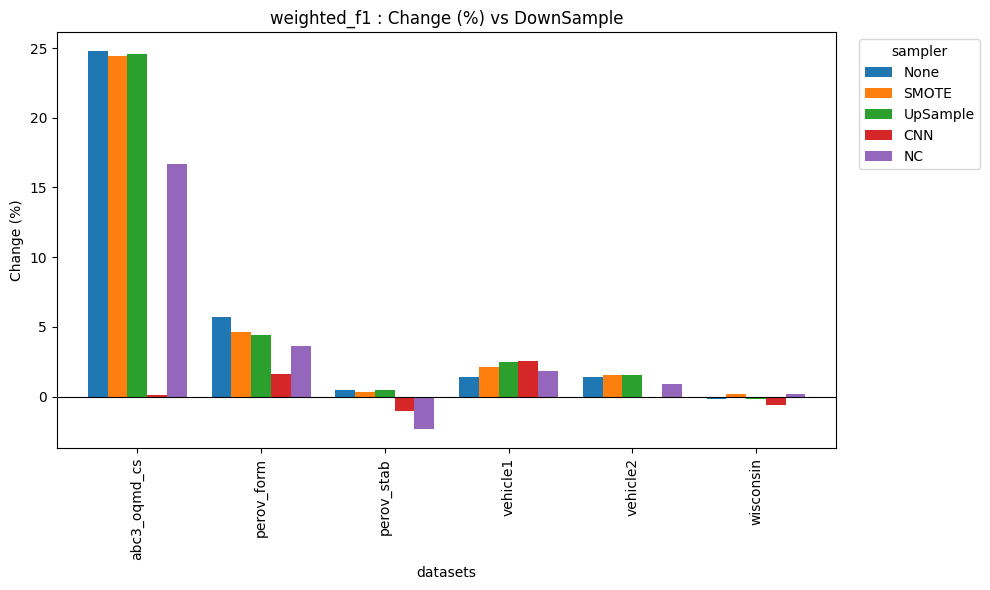

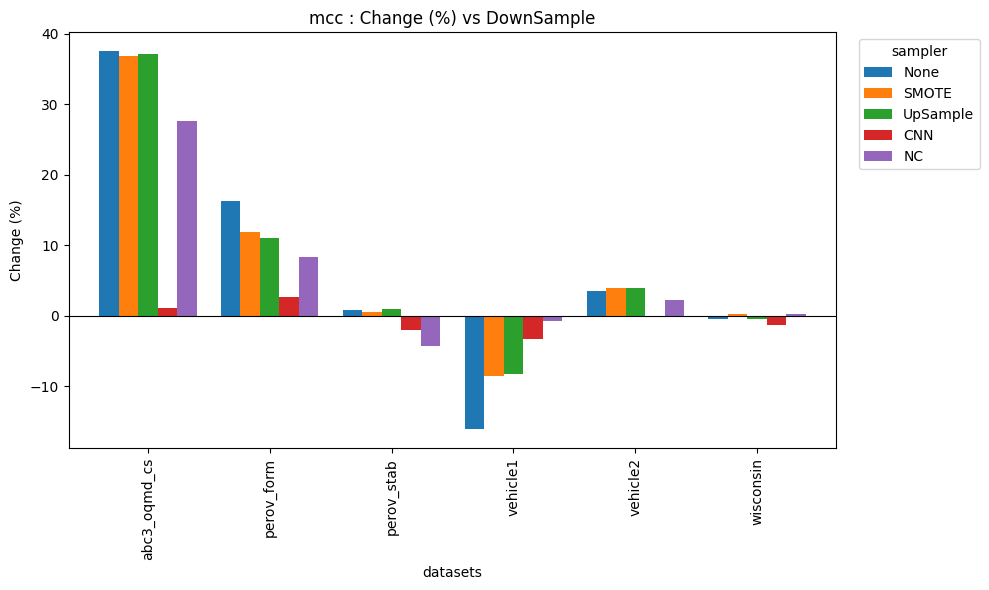

In [13]:
baseline = "DownSample"
OUT_DIR = pathlib.Path("output")
OUT_DIR.mkdir(exist_ok=True)

for df in df_per_metric:
    metric = df.name
    rel = ((df.subtract(df[baseline], axis=0)
            .div(df[baseline], axis=0))*100).round(2)
    rel = rel.drop(columns=[baseline], errors="ignore")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rel.plot(kind="bar", ax=ax, width=0.8)
    ax.axhline(0, color="black", lw=0.8)
    ax.set_title(f"{metric} : Change (%) vs {baseline}")
    ax.set_ylabel("Change (%)")
    ax.set_xlabel("datasets")
    ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    fig.savefig(OUT_DIR/f"rel_vs_{baseline}_{metric}.png", dpi=300)
    plt.show()
    plt.close(fig)

# 8.  Export CSVs

In [14]:
for df in df_per_metric:
    df.to_csv(OUT_DIR/f"{df.name}.csv")

✅ **Completed**